In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt
# def split_data(source_dir, train_dir, test_dir, val_dir, test_size=0.15, val_size=0.15):
#     files = os.listdir(source_dir)
#     train_files, test_files = train_test_split(files, test_size=(test_size + val_size))
#     val_files, test_files = train_test_split(test_files, test_size=(test_size / (test_size + val_size)))

#     for file in train_files:
#         shutil.copy(os.path.join(source_dir, file), train_dir)
#     for file in test_files:
#         shutil.copy(os.path.join(source_dir, file), test_dir)
#     for file in val_files:
#         shutil.copy(os.path.join(source_dir, file), val_dir)

# 设置数据集路径
base_dir = 'C:/Users/25232/Desktop/cell_images/cell_images'
categories = ['Parasitized', 'Uninfected']

# 创建训练、测试和验证集的目录
# train_dir = os.path.join(base_dir, 'train')
# test_dir = os.path.join(base_dir, 'test')
# val_dir = os.path.join(base_dir, 'validation')
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)

# 对每个类别执行划分操作
# for category in categories:
#     os.makedirs(os.path.join(train_dir, category), exist_ok=True)
#     os.makedirs(os.path.join(test_dir, category), exist_ok=True)
#     os.makedirs(os.path.join(val_dir, category), exist_ok=True)
#     split_data(os.path.join(base_dir, category), 
#                os.path.join(train_dir, category), 
#                os.path.join(test_dir, category), 
#                os.path.join(val_dir, category))

In [2]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Add this import
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix, f1_score, precision_recall_curve, auc
import numpy as np
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Set image dimensions and batch size
image_width, image_height = 150, 150
batch_size = 32

# Define data transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.RandomResizedCrop(150),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_val_transforms = transforms.Compose([
    transforms.Resize((image_width, image_height)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define custom datasets
class CustomImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(root=data_dir, transform=transform)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

# Create data loaders
train_dataset = CustomImageDataset('C:/Users/25232/Desktop/cell_images/cell_images/train', transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = CustomImageDataset('C:/Users/25232/Desktop/cell_images/cell_images/validation', transform=test_val_transforms)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

test_dataset = CustomImageDataset('C:/Users/25232/Desktop/cell_images/cell_images/test', transform=test_val_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


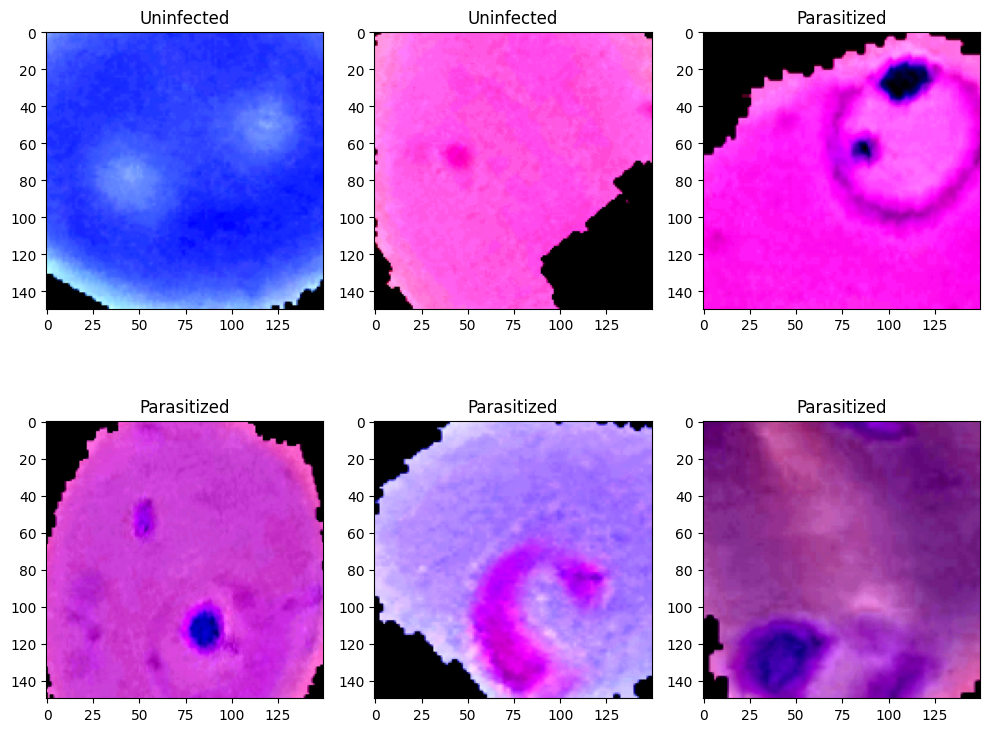

In [3]:
# 数据集可视化
#Dataset visualization
import random
import matplotlib.pyplot as plt

# 输入行列数
m = 2  # 行数
n = 3  # 列数

# 获取标签名称列表
class_names = train_dataset.data.classes

# 创建包含多个子图的图像
fig, axes = plt.subplots(m, n, figsize=(10, 8))

# 随机选择训练集中的m*n张图片进行可视化
num_samples = m * n
selected_indices = random.sample(range(len(train_dataset)), num_samples)

for i in range(m):
    for j in range(n):
        index = selected_indices[i * n + j]  # 获取随机选择的索引
        image, label = train_dataset[index]
        image = image.permute(1, 2, 0)  # 将图片张量的维度顺序调整为(H, W, C)

        # 在当前子图中显示图片
        axes[i, j].imshow(image)
        axes[i, j].set_title(f"{class_names[label]}")  # 使用标签名称代替标签索引

# 调整子图之间的间距和边界
plt.tight_layout()

# 显示图像
plt.show()


In [4]:
# 注意力层设计
#Attention layer design
class AttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(AttentionModule, self).__init__()
        self.attention_weights = nn.Conv2d(in_channels, 1, kernel_size=1)

    def forward(self, x):
        attention_map = torch.sigmoid(self.attention_weights(x))
        return attention_map * x
    
# 残差块设计
#Residual block design
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        x += residual  # 残差连接
        x = self.relu(x)
        return x

In [5]:
# 模型搭建
#Model building


class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.residual_block = ResidualBlock(32, 32)  # 添加残差块
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)  # 添加一层卷积层
        self.attention = AttentionModule(32)
        self.fc = nn.Linear(32 * 37 * 37, 128)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.residual_block(x)  # 使用残差块
        x = F.relu(self.conv3(x))  # 添加的卷积层
        x = self.attention(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.attention = AttentionModule(64)
        self.fc = nn.Linear(64 * 37 * 37, 128)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.attention(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class CombinedCNN(nn.Module):
    def __init__(self):
        super(CombinedCNN, self).__init__()
        self.cnn1 = CNN1()
        self.cnn2 = CNN2()
        self.fc = nn.Linear(256, 2) 

    def forward(self, x):
        output1 = self.cnn1(x)
        output2 = self.cnn2(x)
        combined = torch.cat((output1, output2), dim=1)
        result = self.fc(combined)
        return result

In [6]:
# 打印模型概要
from torchsummary import summary

test = CNN1()
test.to(device)
summary(test, input_size=(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 150]             448
         MaxPool2d-2           [-1, 16, 75, 75]               0
            Conv2d-3           [-1, 32, 75, 75]           4,640
         MaxPool2d-4           [-1, 32, 37, 37]               0
            Conv2d-5           [-1, 32, 37, 37]           9,248
              ReLU-6           [-1, 32, 37, 37]               0
            Conv2d-7           [-1, 32, 37, 37]           9,248
              ReLU-8           [-1, 32, 37, 37]               0
     ResidualBlock-9           [-1, 32, 37, 37]               0
           Conv2d-10           [-1, 32, 37, 37]           9,248
           Conv2d-11            [-1, 1, 37, 37]              33
  AttentionModule-12           [-1, 32, 37, 37]               0
           Linear-13                  [-1, 128]       5,607,552
Total params: 5,640,417
Trainable param

In [7]:
test=CNN2()
test.to(device)
summary(test, input_size=(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             896
         MaxPool2d-2           [-1, 32, 75, 75]               0
            Conv2d-3           [-1, 64, 75, 75]          18,496
         MaxPool2d-4           [-1, 64, 37, 37]               0
            Conv2d-5            [-1, 1, 37, 37]              65
   AttentionModule-6           [-1, 64, 37, 37]               0
            Linear-7                  [-1, 128]      11,214,976
Total params: 11,234,433
Trainable params: 11,234,433
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 10.96
Params size (MB): 42.86
Estimated Total Size (MB): 54.07
----------------------------------------------------------------


In [8]:
test=CombinedCNN()
test.to(device)
summary(test, input_size=(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 150]             448
         MaxPool2d-2           [-1, 16, 75, 75]               0
            Conv2d-3           [-1, 32, 75, 75]           4,640
         MaxPool2d-4           [-1, 32, 37, 37]               0
            Conv2d-5           [-1, 32, 37, 37]           9,248
              ReLU-6           [-1, 32, 37, 37]               0
            Conv2d-7           [-1, 32, 37, 37]           9,248
              ReLU-8           [-1, 32, 37, 37]               0
     ResidualBlock-9           [-1, 32, 37, 37]               0
           Conv2d-10           [-1, 32, 37, 37]           9,248
           Conv2d-11            [-1, 1, 37, 37]              33
  AttentionModule-12           [-1, 32, 37, 37]               0
           Linear-13                  [-1, 128]       5,607,552
             CNN1-14                  [

In [9]:
# 自定义交叉熵损失函数
#Custom cross entropy loss function
class CustomCrossEntropyLoss:
    def __init__(self):
        pass

    def forward(self, outputs, targets):
        batch_size = outputs.size(0)
        
        # 计算softmax
        #Calculate softmax
        max_outputs = torch.max(outputs, dim=1, keepdim=True).values
        exp_outputs = torch.exp(outputs - max_outputs)  # 避免指数溢出
                                                        #Avoiding exponential overflow
        probs = exp_outputs / exp_outputs.sum(dim=1, keepdim=True)

        # 获取对应目标类别的概率
        #Obtain the probability of corresponding target categories
        target_probs = probs[range(batch_size), targets]
        
        # 添加一个很小的常数，避免对数计算中出现 0 值
        #Add a very small constant to avoid zero values in logarithmic calculations
        eps = 1e-8
        target_probs = torch.clamp(target_probs, min=eps)
        
        # 计算交叉熵损失
        #Calculate cross entropy loss
        loss = -torch.log(target_probs).mean()
        
        return loss

#自定义准确度函数
#Custom accuracy function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = torch.sum(preds == labels).item()
    total = labels.size(0)
    acc = correct / total
    return acc

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix, f1_score, precision_recall_curve, auc
import numpy as np
from tqdm import tqdm

# Check for GPU availability and set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the model and move it to the device
model = CombinedCNN().to(device)
# criterion = nn.CrossEntropyLoss()  # Custom loss function can be defined here
criterion = CustomCrossEntropyLoss()  # 自定义损失函数

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)  # 添加L2正则化项，weight_decay 为正则化系数

def train_model(model, train_loader, val_loader, optimizer, epochs=2):
    model.train()
    loss_history = []  # List to store loss values for each epoch
    accuracy_history = []  # List to store accuracy values for each epoch
    f1_history = []  # List to store F1 scores for each epoch
    specificity_history = []
    sensitivity_history = []
    precision_history = []
    recall_history = []
    
    val_loss_history = []  # List to store validation loss values for each epoch
    val_accuracy_history = []  # List to store validation accuracy values for each epoch
    val_f1_history = []  # List to store validation F1 scores for each epoch
    val_specificity_history = []
    val_sensitivity_history = []
    val_precision_history = []
    val_recall_history = []

    # 梯度置零
    optimizer.zero_grad()

    for epoch in range(epochs):
        running_loss = 0.0
        total_correct = 0
        total_samples = 0
        all_labels = []
        all_preds = []

        loop = tqdm(enumerate(train_loader, 0), total =len(train_loader))
        
        for i, data in loop:
        # for i, data in enumerate(tqdm(train_loader), 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion.forward(outputs, labels)

            
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            running_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # 更新信息
            loop.set_description(f'Epoch {epoch+1}/{epochs} Loss: {running_loss/(i+1):.4f}')
            # loop.set_postfix()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * total_correct / total_samples
        
        
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)

        # Convert to numpy arrays
        all_labels = np.array(all_labels)
        all_preds = np.array(all_preds)

        # Calculate F1 score
        f1 = f1_score(all_labels, all_preds)
        f1_history.append(f1)

        # 计算 recall precision
        recall = recall_score(all_labels, all_preds)
        recall_history.append(recall)
        precision = precision_score(all_labels, all_preds)
        precision_history.append(precision)

        # 计算 sensitivity specificity  
        cm = confusion_matrix(all_labels, all_preds)
        true_negatives = cm[0, 0]
        false_positives = cm[0, 1]
        false_negatives = cm[1, 0]
        true_positives = cm[1, 1]
    
        sensitivity = true_positives / (true_positives + false_negatives)
        specificity = true_negatives / (true_negatives + false_positives)
        sensitivity_history.append(sensitivity)
        specificity_history.append(specificity)

        
        # 验证集
        #Verification set
        val_running_loss = 0.0
        val_total_correct = 0
        val_total_samples = 0
        val_all_labels = []
        val_all_preds = []
        
        # 切换到评估模式
        #Switch to evaluation mode
        model.eval()
        
        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                val_outputs = model(inputs)
                val_loss = criterion.forward(val_outputs, labels)

                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total_samples += labels.size(0)
                val_total_correct += (val_predicted == labels).sum().item()
                val_running_loss += val_loss.item()
                val_all_labels.extend(labels.cpu().numpy())
                val_all_preds.extend(val_predicted.cpu().numpy())

            val_epoch_loss = val_running_loss / len(val_loader)
            
            val_epoch_accuracy = 100 * val_total_correct / val_total_samples
            
            val_loss_history.append(val_epoch_loss)
            val_accuracy_history.append(val_epoch_accuracy)

            # Convert to numpy arrays
            val_all_labels = np.array(val_all_labels)
            val_all_preds = np.array(val_all_preds)

            # Calculate F1 score
            val_f1 = f1_score(val_all_labels, val_all_preds)
            val_f1_history.append(val_f1)

            # 计算 sensitivity specificity  
            val_cm = confusion_matrix(val_all_labels, val_all_preds)
            val_true_negatives = val_cm[0, 0]
            val_false_positives = val_cm[0, 1]
            val_false_negatives = val_cm[1, 0]
            val_true_positives = val_cm[1, 1]
    
            val_sensitivity = val_true_positives / (val_true_positives + val_false_negatives)
            val_specificity = val_true_negatives / (val_true_negatives + val_false_positives)
            val_sensitivity_history.append(val_sensitivity)
            val_specificity_history.append(val_specificity)
            
            # 计算 recall precision
            val_recall = recall_score(val_all_labels, val_all_preds)
            val_precision = precision_score(val_all_labels, val_all_preds)
            val_recall_history.append(val_recall)
            val_precision_history.append(val_precision)


    # 关闭进度条 
    loop.close()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, F1-score: {f1:.4f}")
        
    return loss_history, val_loss_history, accuracy_history, val_accuracy_history, f1_history, val_f1_history, specificity_history, sensitivity_history, val_sensitivity_history, val_specificity_history, recall_history, val_recall_history, precision_history, val_precision_history

In [11]:
# Example usage
epochs = 15
loss_history, val_loss_history, accuracy_history, val_accuracy_history, f1_history, val_f1_history, specificity_history, sensitivity_history, val_sensitivity_history, val_specificity_history, recall_history, val_recall_history, precision_history, val_precision_history = train_model(model, train_loader, validation_loader, optimizer, epochs=epochs)

Epoch 15/15 Loss: 0.3448: 100%|██████████| 603/603 [02:12<00:00,  4.55it/s]


Epoch 15, Loss: 0.3448, Accuracy: 85.45%, F1-score: 0.8662


In [12]:
# Plot loss, accuracy, and F1 score
def plot_train_val_indicator(figsize, loss_history, val_loss_history, accuracy_history, val_accuracy_history, f1_history, val_f1_history, specificity_history, sensitivity_history, val_sensitivity_history, val_specificity_history, recall_history, val_recall_history, precision_history, val_precision_history):
    # 定义调色板
    import seaborn as sns
    palette = sns.color_palette("husl", 14)
    
    plt.figure(figsize=figsize)
    plt.subplot(3, 3, 1)
    plt.plot(range(1, epochs+1), loss_history, marker='o', linestyle='-', color=palette[0], label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss_history, marker='o', linestyle='-', color=palette[1], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend(bbox_to_anchor=(0, 0), loc='lower left')
    
    plt.subplot(3, 3, 2)
    plt.plot(range(1, epochs+1), accuracy_history, marker='o', linestyle='-', color=palette[2], label='Training Accuracy')
    plt.plot(range(1, epochs+1), val_accuracy_history, marker='o', linestyle='-', color=palette[3], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend(bbox_to_anchor=(0, 0), loc='lower left')
    
    plt.subplot(3, 3, 3)
    plt.plot(range(1, epochs+1), f1_history, marker='o', linestyle='-', color=palette[4], label='Training F1 Score')
    plt.plot(range(1, epochs+1), val_f1_history, marker='o', linestyle='-', color=palette[5], label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend(bbox_to_anchor=(0, 0), loc='lower left')
    
    plt.subplot(3, 3, 4)
    plt.plot(range(1, epochs+1), specificity_history, marker='o', linestyle='-', color=palette[6], label='Training F1 Score')
    plt.plot(range(1, epochs+1), val_specificity_history, marker='o', linestyle='-', color=palette[7], label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Specificity')
    plt.title('Training and Validation Specificity')
    plt.legend(bbox_to_anchor=(0, 0), loc='lower left')
    
    plt.subplot(3, 3, 5)
    plt.plot(range(1, epochs+1), sensitivity_history, marker='o', linestyle='-', color=palette[8], label='Training F1 Score')
    plt.plot(range(1, epochs+1), val_sensitivity_history, marker='o', linestyle='-', color=palette[9], label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Sensitivity')
    plt.title('Training and Validation Sensitivity_history')
    plt.legend(bbox_to_anchor=(0, 0), loc='lower left')
    
    plt.subplot(3, 3, 6)
    plt.plot(range(1, epochs+1), recall_history, marker='o', linestyle='-', color=palette[10], label='Training F1 Score')
    plt.plot(range(1, epochs+1), val_recall_history, marker='o', linestyle='-', color=palette[11], label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend(bbox_to_anchor=(0, 0), loc='lower left')
    
    plt.subplot(3, 3, 7)
    plt.plot(range(1, epochs+1), precision_history, marker='o', linestyle='-', color=palette[12], label='Training F1 Score')
    plt.plot(range(1, epochs+1), val_precision_history, marker='o', linestyle='-', color=palette[13], label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('precision')
    plt.title('Training and Validation Precision')
    plt.legend(bbox_to_anchor=(0, 0), loc='lower left')
    
    plt.tight_layout()
    plt.show()

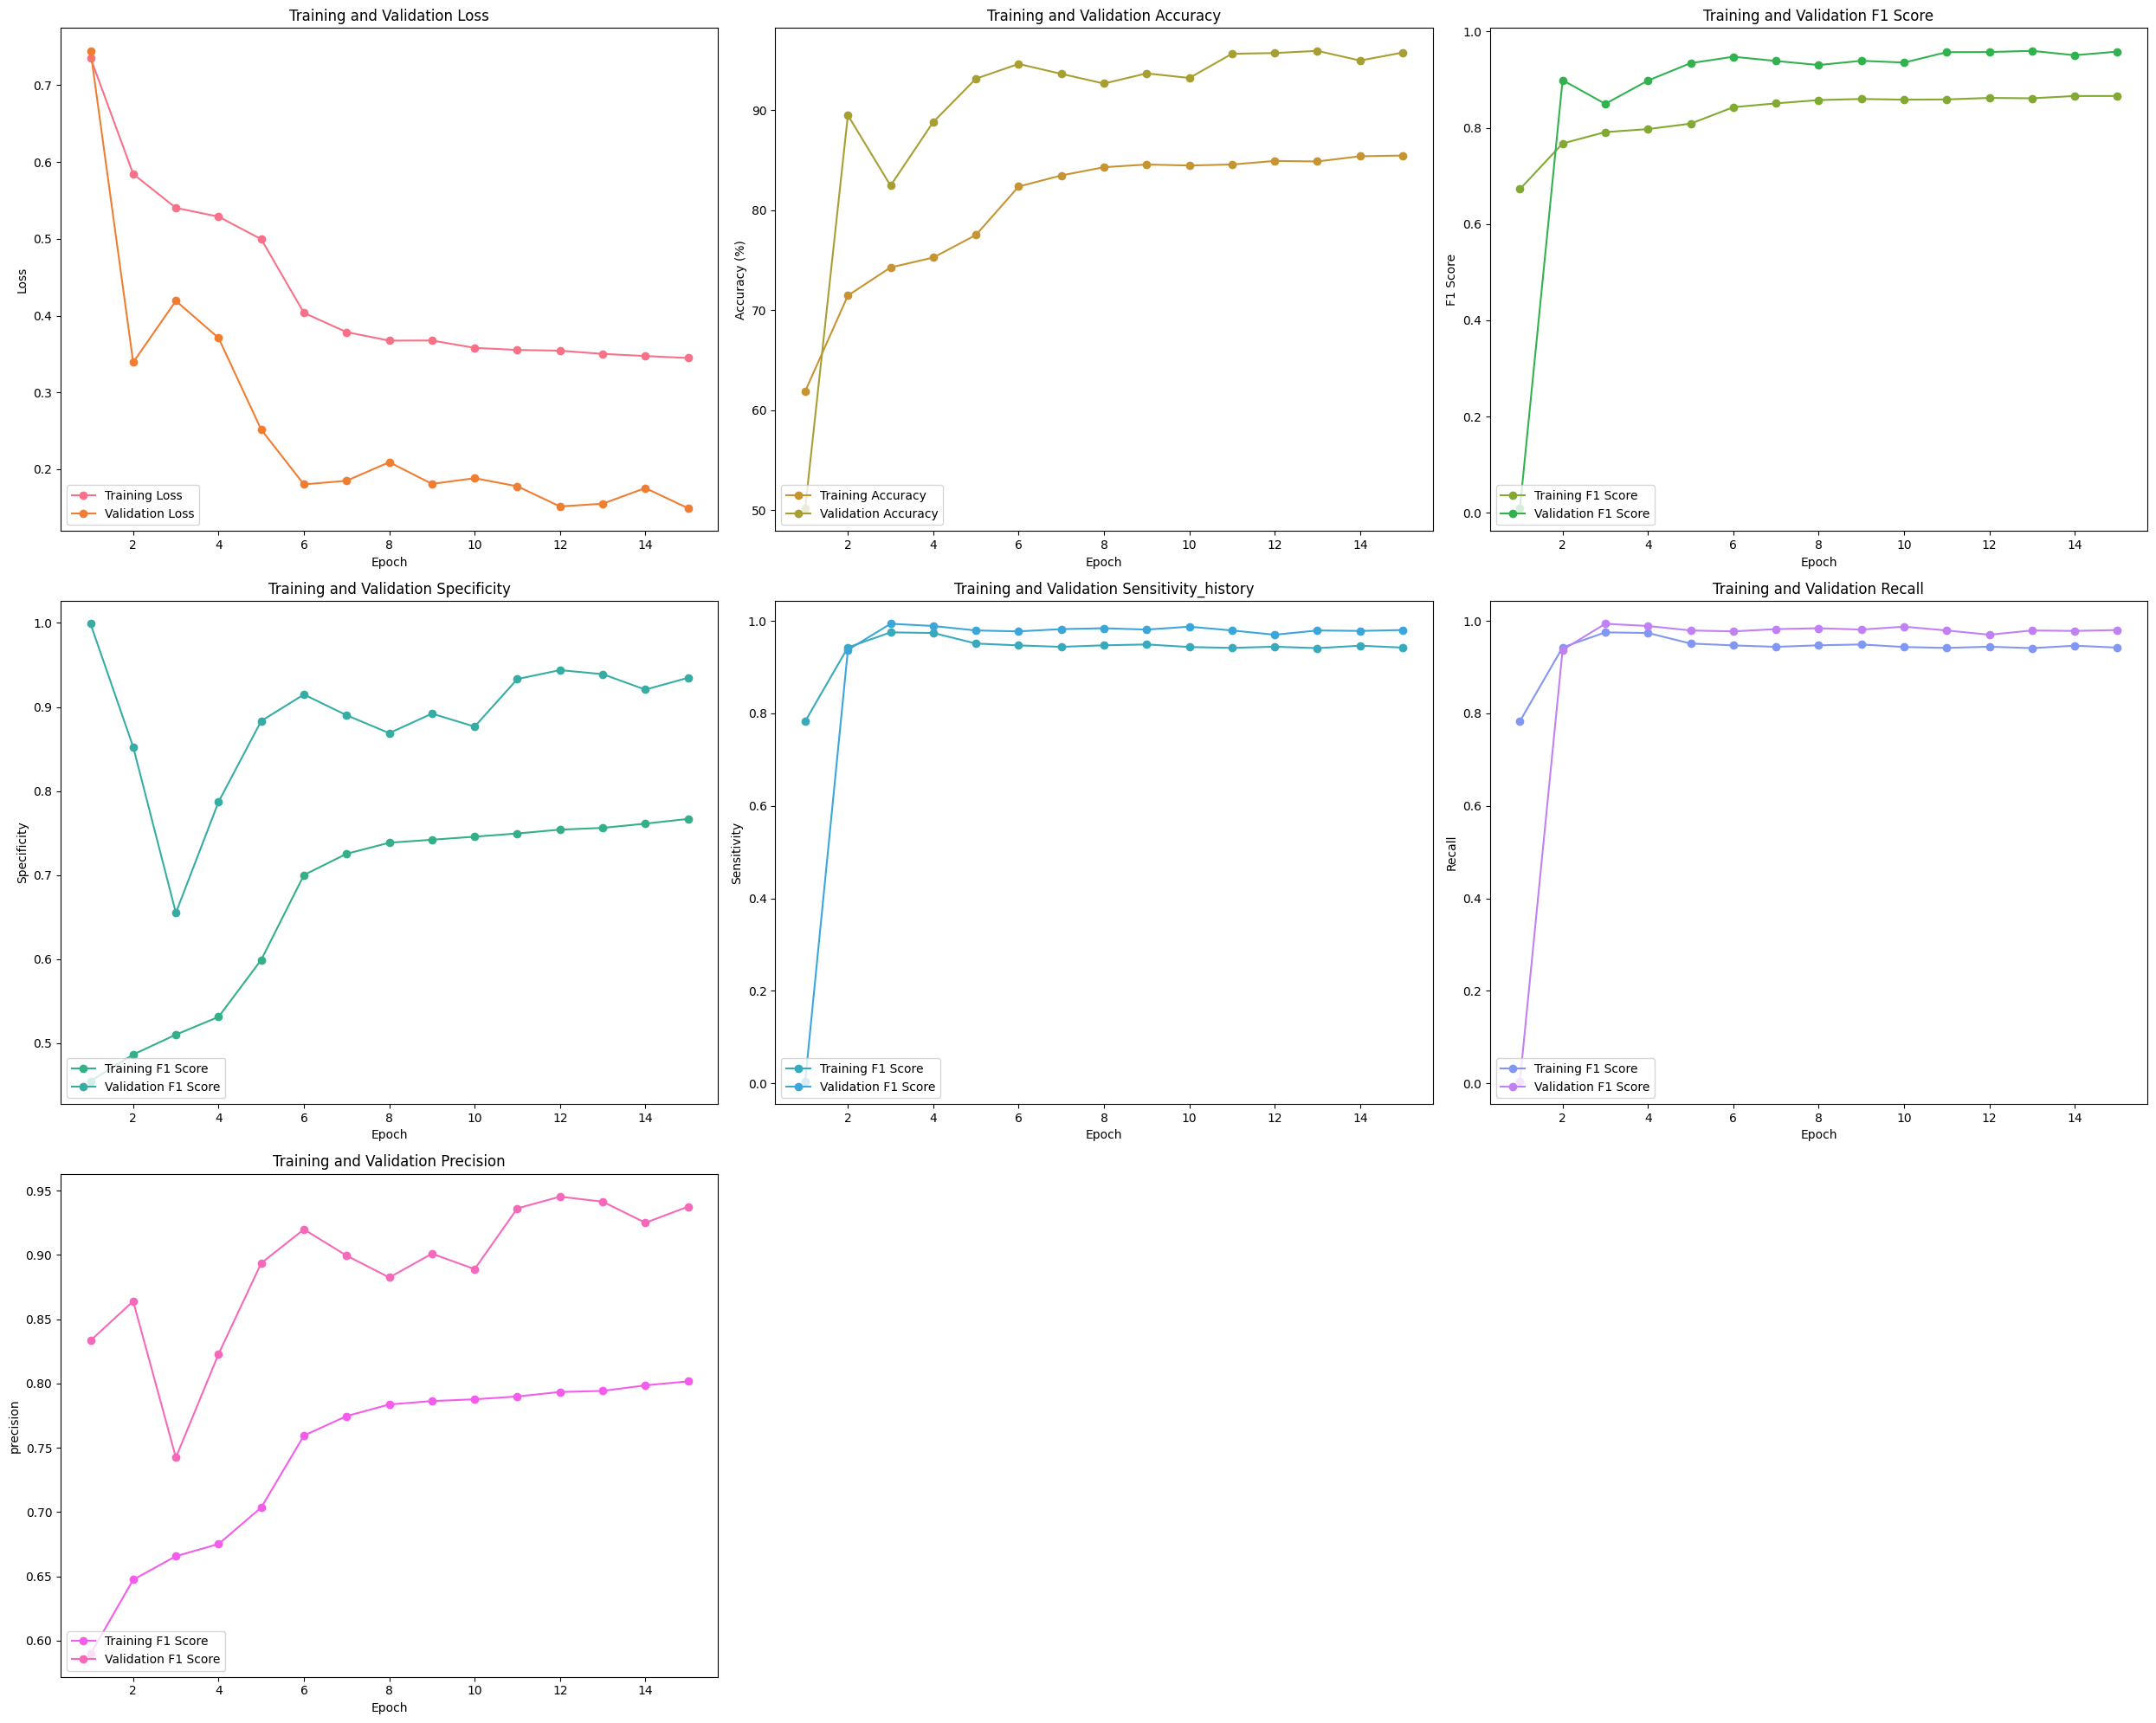

In [13]:
# 可视化训练集与验证集过程中的关键指标
figsize = (25,20) # 设置窗口大小
plot_train_val_indicator(figsize, loss_history, val_loss_history, accuracy_history, val_accuracy_history, f1_history, val_f1_history, specificity_history, sensitivity_history, val_sensitivity_history, val_specificity_history, recall_history, val_recall_history, precision_history, val_precision_history)

In [14]:
import numpy as np
import torch
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix, precision_recall_curve, auc, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
def evaluate_model(model, validation_loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []  # Store probabilities for ROC-AUC and Precision-Recall curves

    with torch.no_grad():
        for data in validation_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())  # Probabilities

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Calculate metrics
    accuracy = np.mean(all_labels == all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs[:, 1])
    recall_score_val = recall_score(all_labels, all_preds)
    precision_score_val = precision_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    
    cm = confusion_matrix(all_labels, all_preds)
    true_negatives = cm[0, 0]
    false_positives = cm[0, 1]
    false_negatives = cm[1, 0]
    true_positives = cm[1, 1]
    
    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)
    # ROC-AUC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])

    # 绘制分类报告
    report = classification_report(all_labels, all_preds)
    print(report)

    plt.figure(figsize=(18, 4))
    plt.subplot(1, 3, 1)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    # plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(all_labels, all_probs[:, 1])
    pr_auc = auc(recall, precision)
    
    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    # plt.show()
    # plt.figure(figsize=(8, 6))
    plt.subplot(1, 3, 3)
    sns.set(font_scale=1.2)  # Adjust font scale for readability
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    # plt.show()
    plt.tight_layout()
    plt.show()

    # Print other metrics
    print(f"Accuracy: {accuracy}")
    print(f"ROC-AUC: {roc_auc}")
    print(f"Recall: {recall_score_val}")
    print(f"Precision: {precision_score_val}")
    print(f"F1-score: {f1}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision-Recall AUC: {pr_auc}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")

    return accuracy, roc_auc, recall_score_val, precision_score_val, f1, sensitivity, specificity, pr_auc, cm, fpr, tpr

              precision    recall  f1-score   support

           0       0.98      0.93      0.96      2067
           1       0.94      0.98      0.96      2067

    accuracy                           0.96      4134
   macro avg       0.96      0.96      0.96      4134
weighted avg       0.96      0.96      0.96      4134



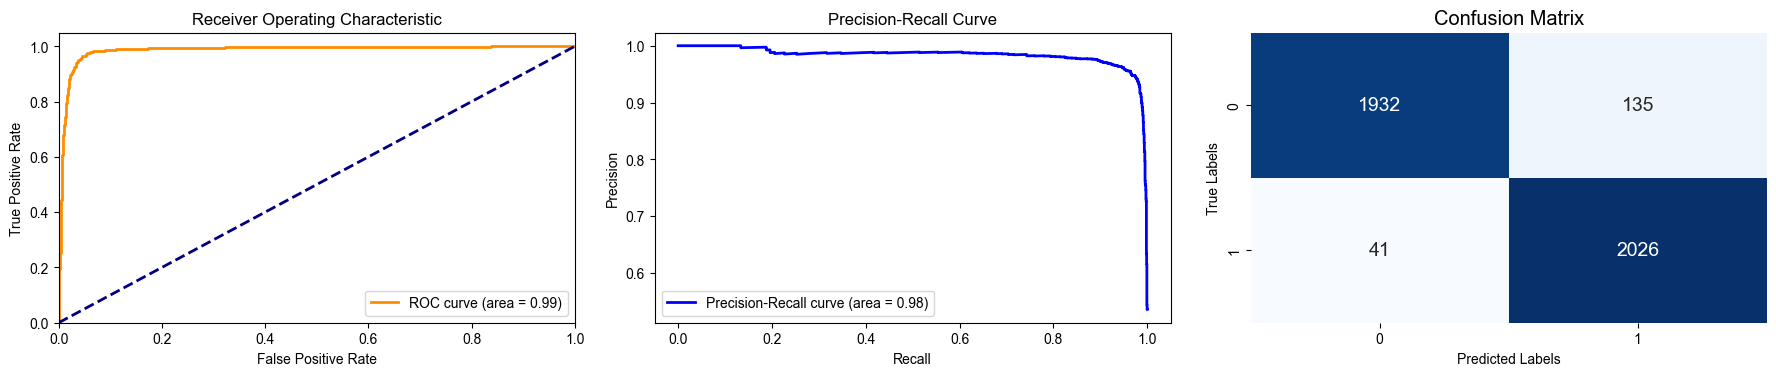

Accuracy: 0.957426221577165
ROC-AUC: 0.9865502286840293
Recall: 0.9801644895984518
Precision: 0.9375289217954651
F1-score: 0.9583727530747398
Confusion Matrix:
[[1932  135]
 [  41 2026]]
Precision-Recall AUC: 0.9831933682777902
Sensitivity: 0.9801644895984518
Specificity: 0.9346879535558781


In [15]:
# 验证集
# 可视化与分类报表
#Verification set
#Visualization and Classification Reports
accuracy, roc_auc, recall_score_val, precision_score_val, f1, sensitivity, specificity, pr_auc, cm, fpr, tpr = evaluate_model(model, validation_loader,device)

              precision    recall  f1-score   support

           0       0.98      0.93      0.96      2067
           1       0.94      0.98      0.96      2067

    accuracy                           0.96      4134
   macro avg       0.96      0.96      0.96      4134
weighted avg       0.96      0.96      0.96      4134



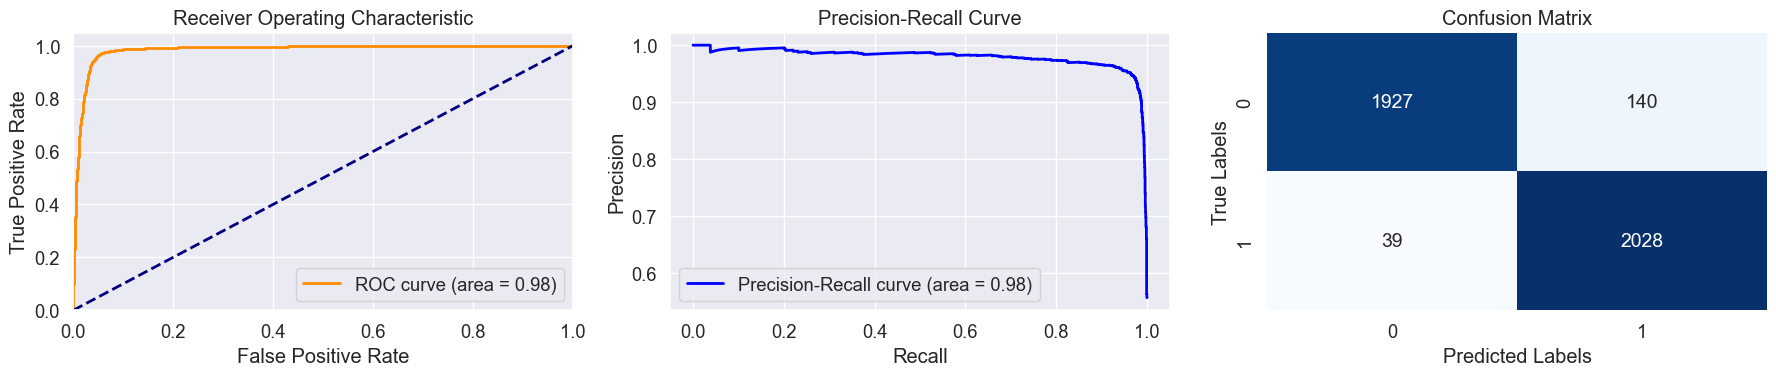

Accuracy: 0.9567005321722303
ROC-AUC: 0.984000192861819
Recall: 0.9811320754716981
Precision: 0.9354243542435424
F1-score: 0.9577331759149941
Confusion Matrix:
[[1927  140]
 [  39 2028]]
Precision-Recall AUC: 0.9792851609310605
Sensitivity: 0.9811320754716981
Specificity: 0.9322689888727624


In [16]:
# 测试集
# 可视化与分类报表
#Test set
#Visualization and Classification Reports
test_accuracy, test_roc_auc, test_recall_score_val, test_precision_score_val, test_f1, test_sensitivity, test_specificity, test_pr_auc, test_cm, test_fpr, test_tpr = evaluate_model(model, test_loader,device)

In [ ]:
# import torch

# criterion = CustomCrossEntropyLoss()


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 使用GPU或CPU

# mymodel.to(device)
# mymodel.eval()  # 将模型切换到评估模式，不进行梯度更新

# test_loss = 0.0
# total_samples = 0

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         outputs = mymodel(inputs)
#         loss = criterion.forward(outputs, labels)  # 使用自定义损失函数

#         test_loss += loss.item() * len(labels)
#         total_samples += len(labels)

# test_loss /= total_samples
# print(f"Test Loss: {test_loss}")


# 使用预训练模型 VGG16

In [20]:
import torch
import torchvision.models as models
import torch.nn as nn

# 加载预训练的 VGG16 模型
vgg16 = models.vgg16(pretrained=True)

# 设置分类类别数
num_classes = 2

# 将全连接层替换为符合任务需求的新顶层
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, num_classes)  #  num_classes 是任务中的类别数

# 可选：冻结预训练模型的参数
for param in vgg16.features.parameters():
    param.requires_grad = False


# 训练模型
# Check for GPU availability and set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the model and move it to the device
vgg_model = vgg16.to(device)
# criterion = nn.CrossEntropyLoss()  # Custom loss function can be defined here
criterion = CustomCrossEntropyLoss()  # 自定义损失函数

vgg_optimizer = optim.Adam(vgg_model.parameters(), lr=0.001)

# Example usage
epochs = 8
vgg_loss_history, vgg_val_loss_history, vgg_accuracy_history, vgg_val_accuracy_history, vgg_f1_history, vgg_val_f1_history, vgg_specificity_history, vgg_sensitivity_history, vgg_val_sensitivity_history, vgg_val_specificity_history, vgg_recall_history, vgg_val_recall_history, vgg_precision_history, vgg_val_precision_history = train_model(vgg_model, train_loader, validation_loader, vgg_optimizer, epochs=epochs)


c:\Users\25232\.conda\envs\tflearn\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
c:\Users\25232\.conda\envs\tflearn\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 8/8 Loss: 0.3623: 100%|██████████| 603/603 [20:19<00:00,  2.02s/it]


Epoch 8, Loss: 0.3623, Accuracy: 83.90%, F1-score: 0.8490


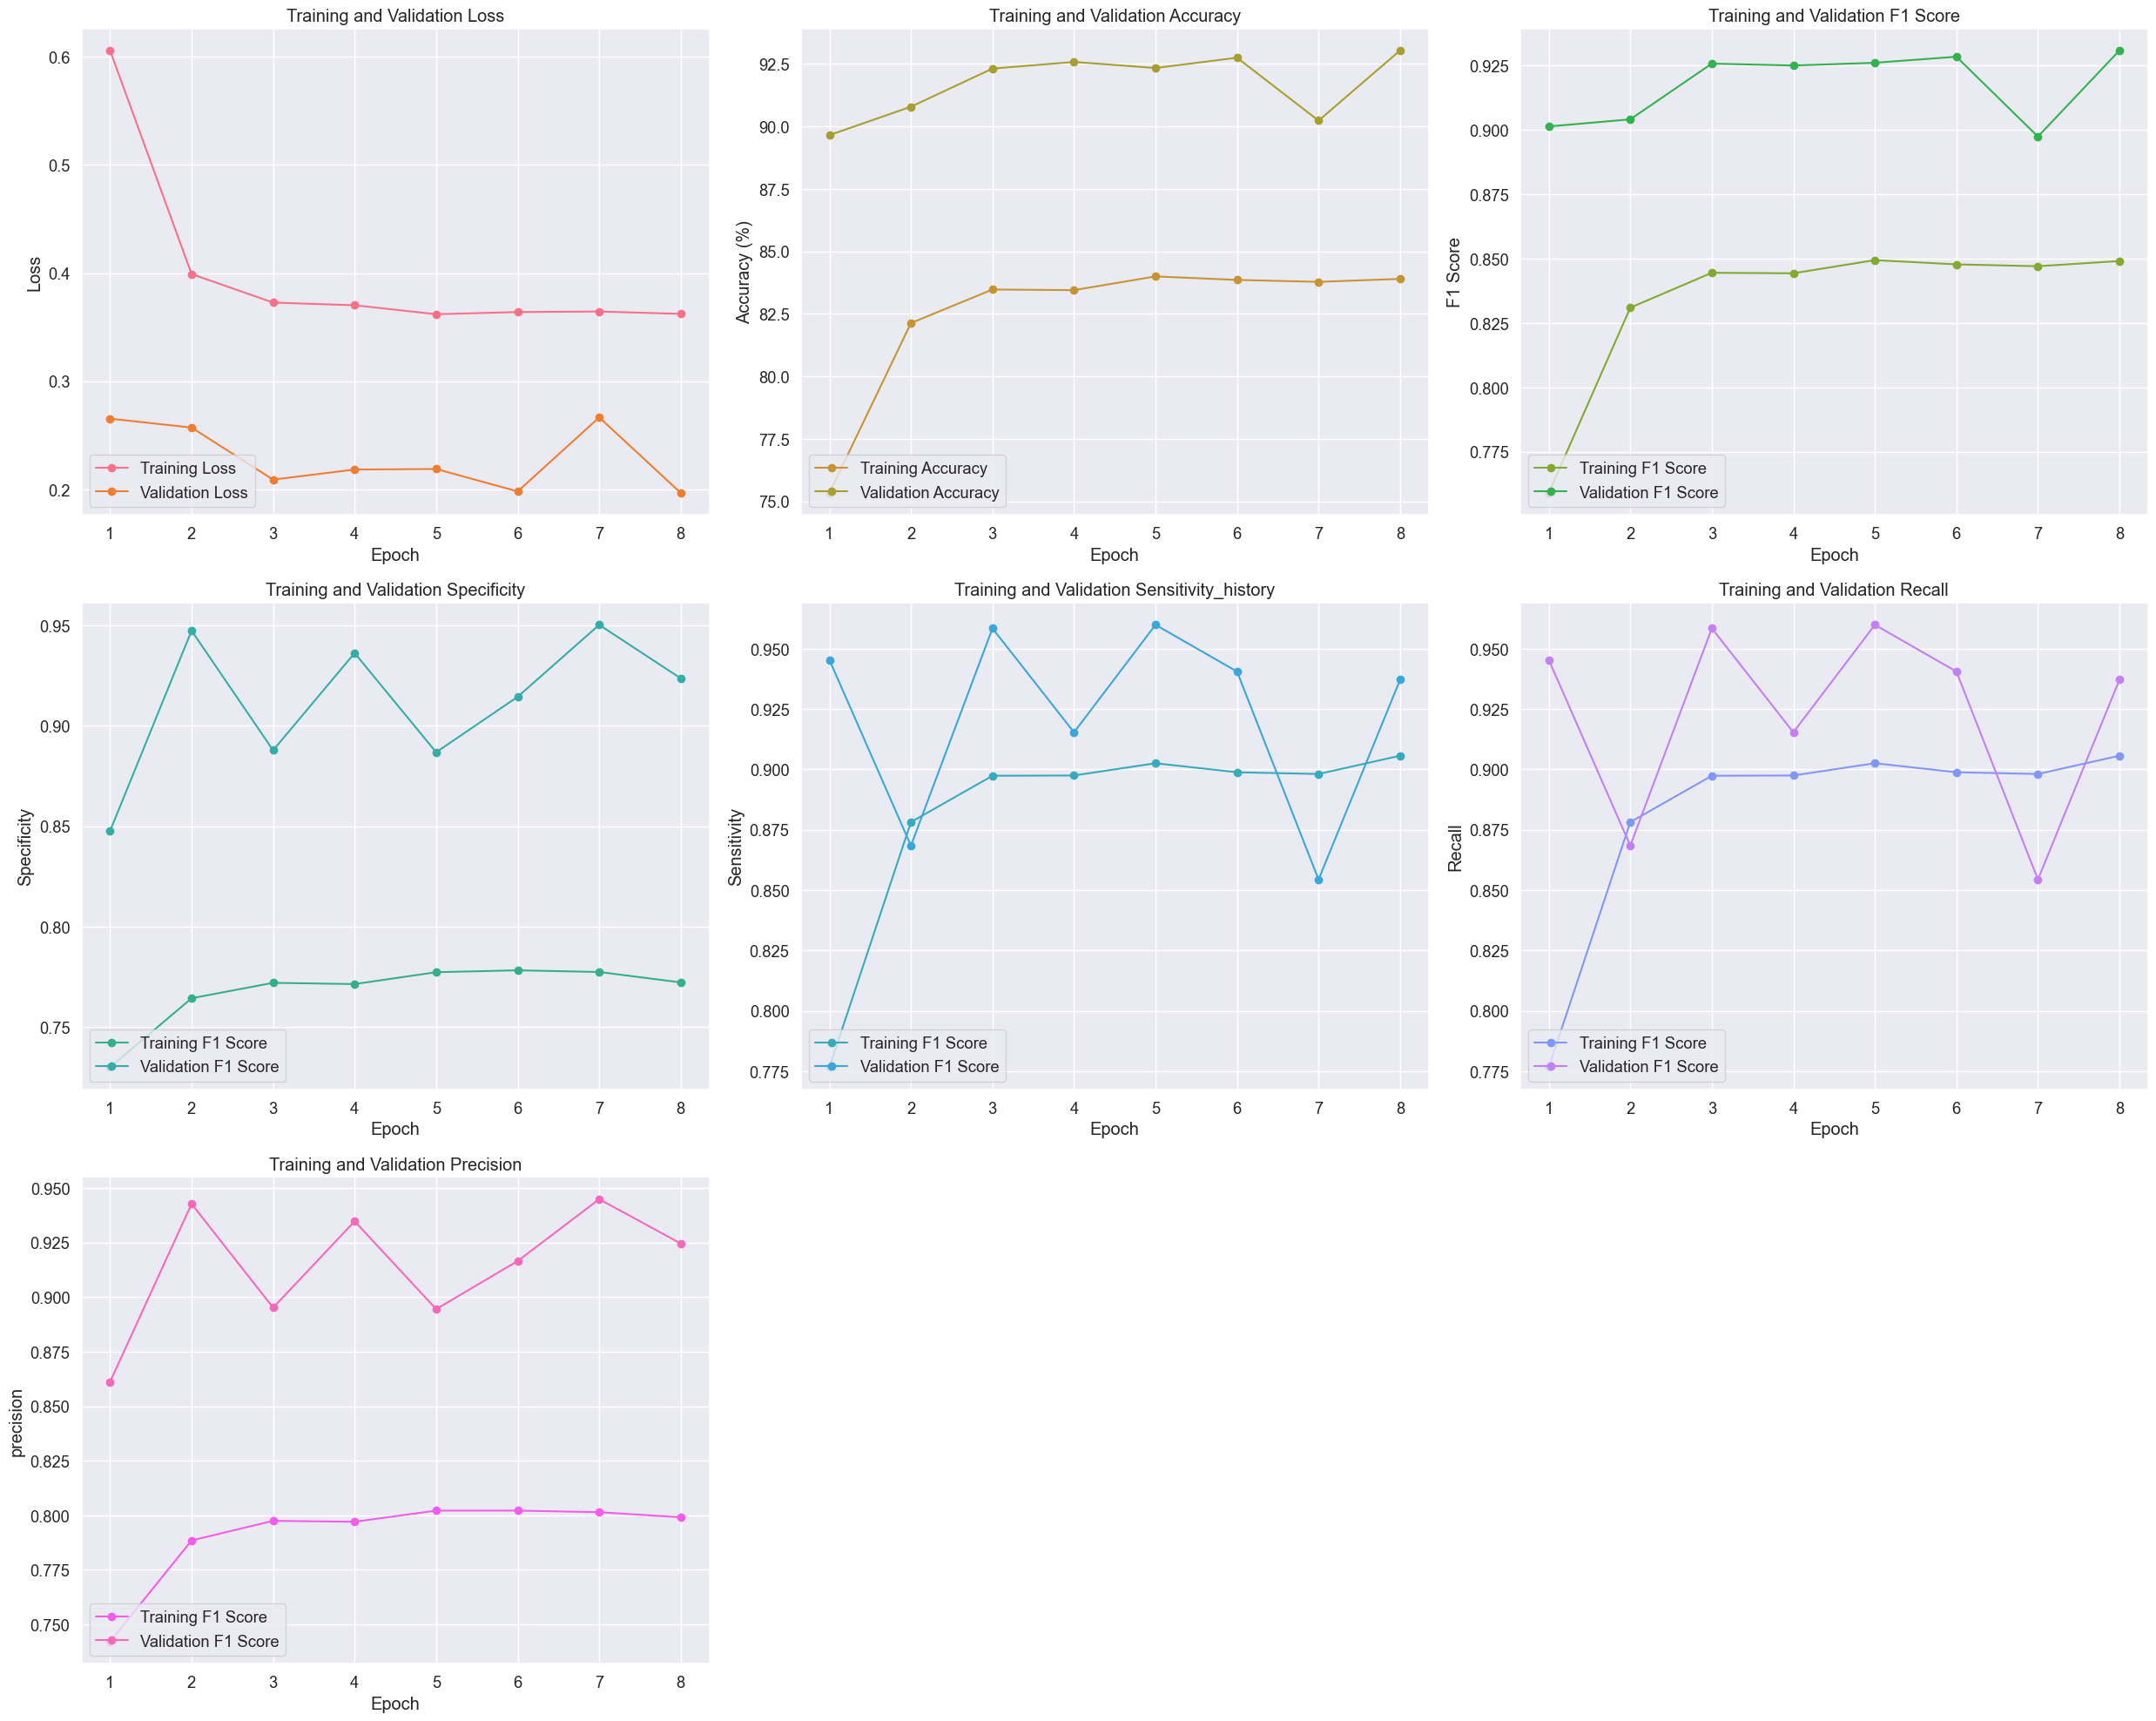

In [21]:
# 可视化训练集与验证集过程中的关键指标
#Key indicators in the process of visualizing training and validation sets
figsize = (25,20)
plot_train_val_indicator(figsize, vgg_loss_history, vgg_val_loss_history, vgg_accuracy_history, vgg_val_accuracy_history, vgg_f1_history, vgg_val_f1_history, vgg_specificity_history, vgg_sensitivity_history, vgg_val_sensitivity_history, vgg_val_specificity_history, vgg_recall_history, vgg_val_recall_history, vgg_precision_history, vgg_val_precision_history)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2067
           1       0.92      0.94      0.93      2067

    accuracy                           0.93      4134
   macro avg       0.93      0.93      0.93      4134
weighted avg       0.93      0.93      0.93      4134



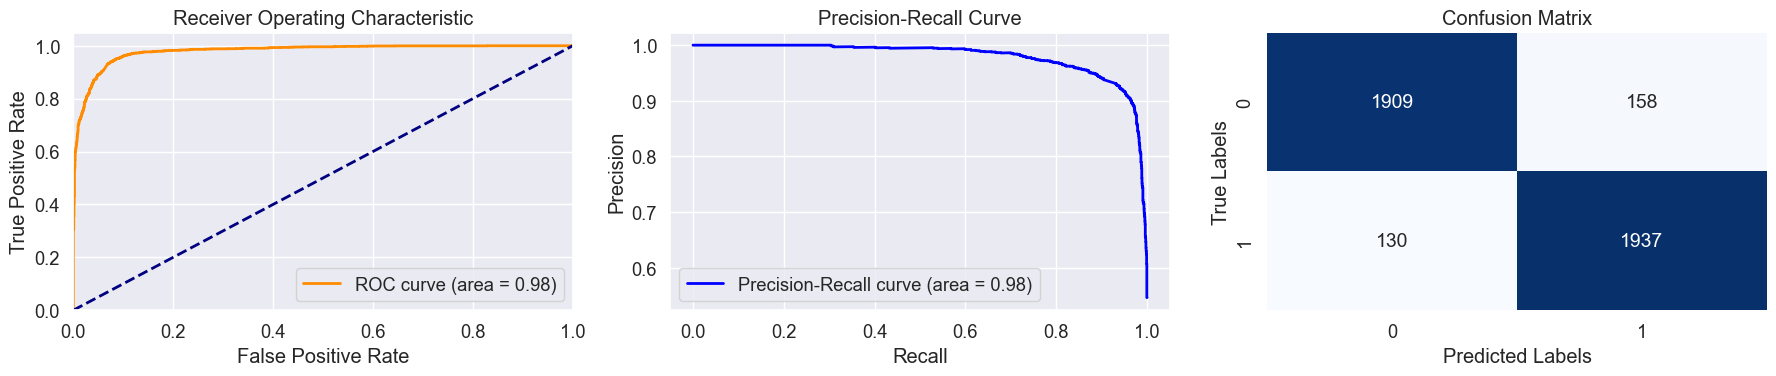

Accuracy: 0.93033381712627
ROC-AUC: 0.9788055627527654
Recall: 0.9371069182389937
Precision: 0.924582338902148
F1-score: 0.9308024987986545
Confusion Matrix:
[[1909  158]
 [ 130 1937]]
Precision-Recall AUC: 0.9790216980932939
Sensitivity: 0.9371069182389937
Specificity: 0.9235607160135462


In [25]:
# 验证集
# 可视化与分类报表
#Verification set
#Visualization and Classification Reports
vgg_accuracy, vgg_roc_auc, vgg_recall_score_val, vgg_precision_score_val, vgg_f1, vgg_sensitivity, vgg_specificity, vgg_pr_auc, vgg_cm, vgg_fpr, vgg_tpr = evaluate_model(vgg_model, validation_loader,device)

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2067
           1       0.92      0.94      0.93      2067

    accuracy                           0.93      4134
   macro avg       0.93      0.93      0.93      4134
weighted avg       0.93      0.93      0.93      4134



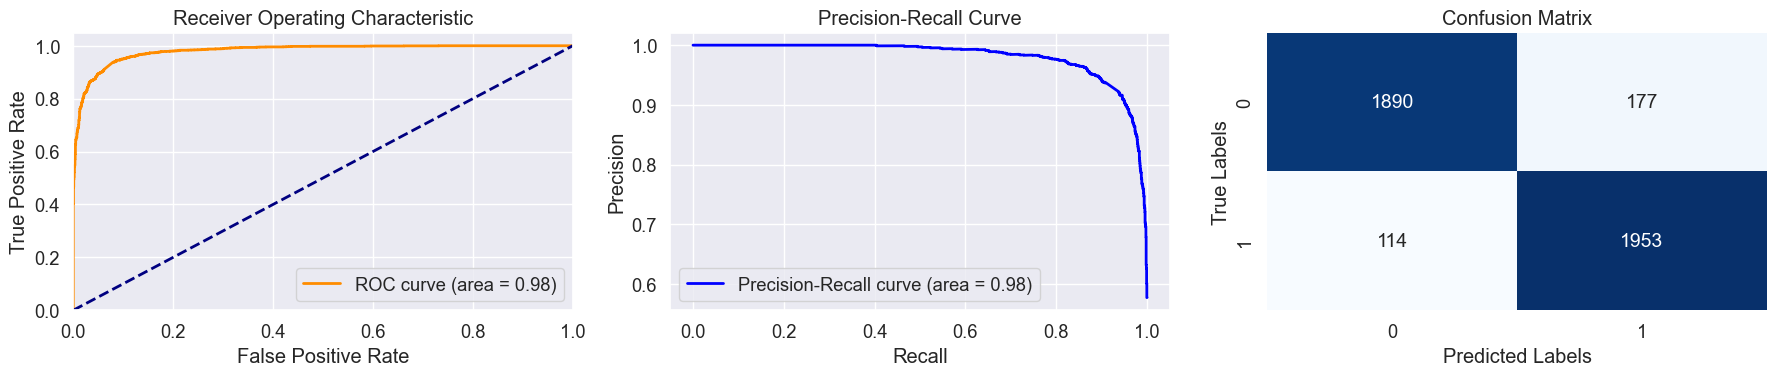

Accuracy: 0.9296081277213353
ROC-AUC: 0.9798308433327739
Recall: 0.9448476052249637
Precision: 0.9169014084507042
F1-score: 0.9306647605432452
Confusion Matrix:
[[1890  177]
 [ 114 1953]]
Precision-Recall AUC: 0.9805398999033733
Sensitivity: 0.9448476052249637
Specificity: 0.9143686502177069


In [24]:
# 测试集
# 可视化与分类报表
#Test set
#Visualization and Classification Reports
test_vgg_accuracy, test_vgg_roc_auc, test_vgg_recall_score_val, test_vgg_precision_score_val, test_vgg_f1, test_vgg_sensitivity, test_vgg_specificity, test_vgg_pr_auc, test_vgg_cm, test_vgg_fpr, test_vgg_tpr = evaluate_model(vgg_model, test_loader,device)